In [1]:
import gym
import numpy as np
import custom_envs

In [2]:
rng = np.random.default_rng(0)
random_walk = gym.make('gym:random-walk-v0', rng=np.random.default_rng(1))

In [3]:
def generateTrajectory(env, policy, maxSteps):
    trajectory = []
    env.reset()
    for step in range(maxSteps):
        # state numbers after considering the terminal states are incremented by 1
        currstate = env.state + 1
        action = rng.choice(env.action_space.n, size=1, p=policy[currstate])[0]
        newstate, r, done, _ = env.step(action)
        exp = (currstate, action, r, newstate+1)
        trajectory.append(exp)
        if done:
            break
    
    return trajectory

In [4]:
def generateRandomPolicy(env):
    policy = {}
    for state in range(env.observation_space.n):
        probs = rng.random(size=env.action_space.n)
        probs /= np.sum(probs)
        # state numbers after considering the terminal states are incremented by 1
        policy[state+1] = probs
    
    return policy

In [5]:
policy = generateRandomPolicy(random_walk)

In [6]:
policy

{1: array([0.70246795, 0.29753205]),
 2: array([0.71256866, 0.28743134]),
 3: array([0.47118081, 0.52881919]),
 4: array([0.45402372, 0.54597628]),
 5: array([0.36763775, 0.63236225])}

In [7]:
trajectory = generateTrajectory(random_walk, policy, 10)

In [8]:
trajectory

[(3, 1, 0, 4),
 (4, 0, 0, 5),
 (5, 1, 0, 4),
 (4, 0, 0, 5),
 (5, 1, 0, 4),
 (4, 0, 0, 3),
 (3, 1, 0, 4),
 (4, 1, 0, 3),
 (3, 0, 0, 4),
 (4, 0, 0, 3)]

In [9]:
def decayAlpha(initialValue, finalValue, maxSteps, decayType=None):
    if decayType == "linear":
        return np.linspace(initialValue, finalValue, num=maxSteps)
    elif decayType == "exponential":
        return np.exp(np.linspace(np.log(initialValue), np.log(finalValue), num=maxSteps))
    else:
        return np.repeat(initialValue, maxSteps)

In [10]:
import matplotlib.pyplot as plt

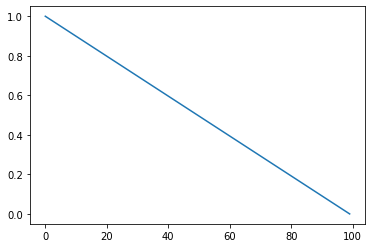

In [11]:
plt.plot(decayAlpha(1, 0, 100, "linear"))
plt.show()

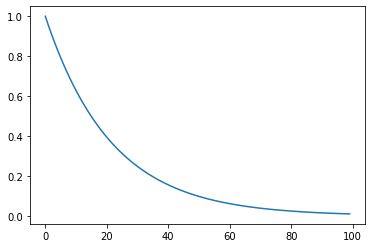

In [12]:
plt.plot(decayAlpha(1, 0.01, 100, "exponential"))
plt.show()

In [13]:
def MonteCarloPrediction(env, policy, gamma, initial_alpha, final_alpha, maxSteps, noEpisodes, firstVisit, decayType=None, noStepsDecay=None):
    v = np.zeros(env.n_states+2) # including terminal states
    v_r = np.zeros((noEpisodes, env.n_states+2))
    if not noStepsDecay:
        noStepsDecay = noEpisodes
    alphas = decayAlpha(initial_alpha, final_alpha, noStepsDecay, decayType)
    for episode in range(noEpisodes):
        if episode < noStepsDecay:
            alpha = alphas[episode]
        else:
            alpha = final_alpha
        t = generateTrajectory(env, policy, maxSteps)
        visited = np.zeros(env.n_states+2)
        for i, (currstate, a, r, newstate) in enumerate(t):
            if visited[currstate] and firstVisit:
                continue
            G = 0
            for j in range(i, len(t)):
                G += np.power(gamma, j-i) * t[j][2]
            v[currstate] += alpha * (G - v[currstate])
        v_r[episode] = v
    
    return v, v_r

In [14]:
# policy doesn't matter, since environment is completely random
v, v_r = MonteCarloPrediction(random_walk, policy, 1, 0.1, 0.1, 10, 10, True)

In [15]:
print(v_r)

[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.1        0.19       0.19
  0.        ]
 [0.         0.         0.         0.271      0.468559   0.40951
  0.        ]
 [0.         0.         0.1        0.40951    0.5217031  0.468559
  0.        ]
 [0.         0.         0.09       0.29853279 0.3422894  0.37953279
  0.        ]
 [0.         0.         0.06561    0.19586736 0.27725442 0.37953279
  0.        ]
 [0.         0.         0.06561    0.12850858 0.16371596 0.34157951
  0.        ]
 [0.         0.         0.06561    0.21565772 0.24734436 0.40742156
  0.        ]
 [0.         0.         0.04304672 0.14149303 0.24734436 0.40742156
  0.        ]]


In [16]:
def TemporalDifferencePrediction(env, policy, gamma, initial_alpha, final_alpha, noEpisodes, decayType=None, noStepsDecay=None):
    v = np.zeros(env.n_states+2) # including terminal states
    v_r = np.zeros((noEpisodes, env.n_states+2))
    if not noStepsDecay:
        noStepsDecay = noEpisodes
    alphas = decayAlpha(initial_alpha, final_alpha, noStepsDecay, decayType)
    for episode in range(noEpisodes):
        if episode < noStepsDecay:
            alpha = alphas[episode]
        else:
            alpha = final_alpha
        currstate = env.reset()
        currstate += 1
        done = False
        while not done:
            action = rng.choice(np.arange(2), size=1, p=policy[currstate])[0]
            newstate, r, done, _ = env.step(action)
            newstate += 1
            td_target = r + gamma * v[newstate] # the if not done condition is redundant since v[terminal state] is always 0
            td_error = td_target - v[currstate]
            v[currstate] += alpha * td_error
            currstate = newstate
            
        v_r[episode] = v
    
    return v, v_r

In [17]:
v, v_r = TemporalDifferencePrediction(random_walk, policy, 1, 0.1, 0.1, 10)

In [57]:
v, v_r = MonteCarloPrediction(random_walk, policy, 1, 0.1, 0.1, 10, 10, True)
print(v_r)
v, v_r = TemporalDifferencePrediction(random_walk, policy, 1, 0.1, 0.1, 100)
print(v)

[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.1        0.19       0.271      0.19       0.1
  0.        ]
 [0.         0.1        0.19       0.3439     0.40951    0.3439
  0.        ]
 [0.         0.0729     0.1121931  0.278559   0.40951    0.3439
  0.        ]
 [0.         0.0729     0.07360989 0.1644863  0.368559   0.3439
  0.        ]
 [0.         0.0729     0.05962401 0.10791946 0.26867951 0.30951
  0.        ]
 [0.         0.06561    0.04829545 0.08741477 0.26867951 0.30951
  0.        ]
 [0.         0.059049   0.04346591 0.07867329 0.26867951 0.30951
  0.        ]
 [0.         0.059049   0.04346591 0.17080596 0.34181156 0.378559
  0.        ]
 [0.         0.059049   0.03911932 0.12451755 0.22426256 0.30663279
  0.        ]]
[0.         0.09673905 0.24075007 0.46375771 0.67793276 0.79557046
 0.        ]


In [20]:
true_est, _ = TemporalDifferencePrediction(random_walk, policy, 1, 0.1, 0.01, 10000, decayType="linear")
print(true_est)

[0.         0.15473469 0.33833495 0.52679271 0.68615387 0.83946431
 0.        ]


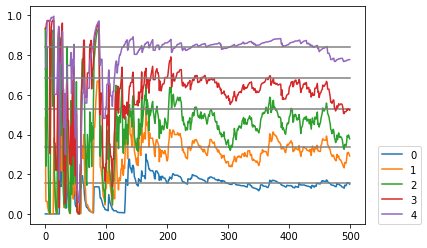

In [43]:
v, v_r = MonteCarloPrediction(random_walk, policy, 0.99, 0.5, 0.01, 50, 500, True, decayType="exponential", noStepsDecay=250)
v_r = np.array(v_r)
for i in range(5):
    plt.plot(np.arange(len(v_r)), v_r[:,i+1], label=i)
    plt.plot(np.arange(len(v_r)), np.ones(len(v_r))*true_est[i+1], c='gray')
plt.legend(loc=(1.04,0))
plt.show()

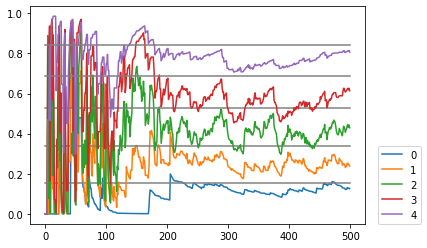

In [22]:
v, v_r = MonteCarloPrediction(random_walk, policy, 0.99, 0.5, 0.01, 50, 500, False, decayType="exponential", noStepsDecay=250)
v_r = np.array(v_r)
for i in range(5):
    plt.plot(np.arange(len(v_r)), v_r[:,i+1], label=i)
    plt.plot(np.arange(len(v_r)), np.ones(len(v_r))*true_est[i+1], c='gray')
plt.legend(loc=(1.04,0))
plt.show()

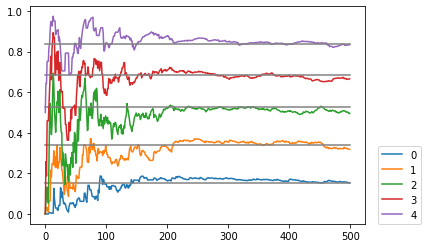

In [23]:
v, v_r = TemporalDifferencePrediction(random_walk, policy, 0.99, 0.5, 0.01, 500, decayType="exponential", noStepsDecay=250)
v_r = np.array(v_r)
for i in range(5):
    plt.plot(np.arange(len(v_r)), v_r[:,i+1], label=i)
    plt.plot(np.arange(len(v_r)), np.ones(len(v_r))*true_est[i+1], c='gray')
plt.legend(loc=(1.04,0))
plt.show()

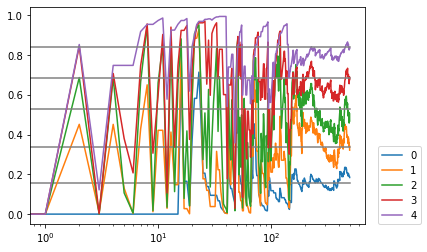

In [24]:
v, v_r = MonteCarloPrediction(random_walk, policy, 0.99, 0.5, 0.01, 50, 500, True, decayType="exponential", noStepsDecay=250)
v_r = np.array(v_r)
plt.xscale("log")
for i in range(5):
    plt.plot(np.arange(len(v_r)), v_r[:,i+1], label=i)
    plt.plot(np.arange(len(v_r)), np.ones(len(v_r))*true_est[i+1], c='gray')
plt.legend(loc=(1.04,0))
plt.show()

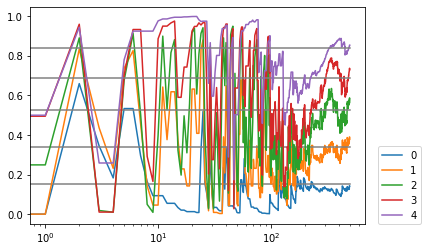

In [25]:
v, v_r = MonteCarloPrediction(random_walk, policy, 0.99, 0.5, 0.01, 50, 500, False, decayType="exponential", noStepsDecay=250)
v_r = np.array(v_r)
plt.xscale("log")
for i in range(5):
    plt.plot(np.arange(len(v_r)), v_r[:,i+1], label=i)
    plt.plot(np.arange(len(v_r)), np.ones(len(v_r))*true_est[i+1], c='gray')
plt.legend(loc=(1.04,0))
plt.show()

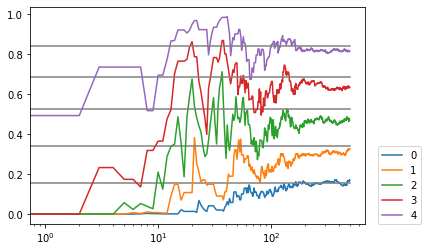

In [26]:
v, v_r = TemporalDifferencePrediction(random_walk, policy, 0.99, 0.5, 0.01, 500, decayType="exponential", noStepsDecay=250)
v_r = np.array(v_r)
plt.xscale("log")
for i in range(5):
    plt.plot(np.arange(len(v_r)), v_r[:,i+1], label=i)
    plt.plot(np.arange(len(v_r)), np.ones(len(v_r))*true_est[i+1], c='gray')
plt.legend(loc=(1.04,0))
plt.show()

In [29]:
def MonteCarloPredictionTarget(env, policy, gamma, initial_alpha, final_alpha, maxSteps, noEpisodes, firstVisit, decayType=None, noStepsDecay=None):
    v = np.zeros(env.n_states+2) # including terminal states
    v_r = np.zeros((noEpisodes, env.n_states+2))
    G_r = np.zeros((noEpisodes, env.n_states+2))
    if not noStepsDecay:
        noStepsDecay = noEpisodes
    alphas = decayAlpha(initial_alpha, final_alpha, noStepsDecay, decayType)
    for episode in range(noEpisodes):
        if episode < noStepsDecay:
            alpha = alphas[episode]
        else:
            alpha = final_alpha
        t = generateTrajectory(env, policy, maxSteps)
        visited = np.zeros(env.n_states+2)
        for i, (currstate, a, r, newstate) in enumerate(t):
            if visited[currstate] and firstVisit:
                continue
            G = 0
            for j in range(i, len(t)):
                G += np.power(gamma, j-i) * t[j][2]
            G_r[episode][currstate] = G
            v[currstate] += alpha * (G - v[currstate])
        v_r[episode] = v
    
    return v, v_r, G_r

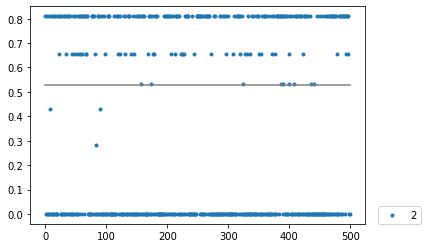

In [51]:
v, v_r, G_r = MonteCarloPredictionTarget(random_walk, policy, 0.9, 0.5, 0.01, 20, 500, True, decayType="exponential", noStepsDecay=250)
i=2
plt.scatter(np.arange(len(v_r)), G_r[:,i+1], label=i, marker='.')
plt.plot(np.arange(len(v_r)), np.ones(len(v_r))*true_est[i+1], c='gray')
plt.legend(loc=(1.04,0))
plt.show()

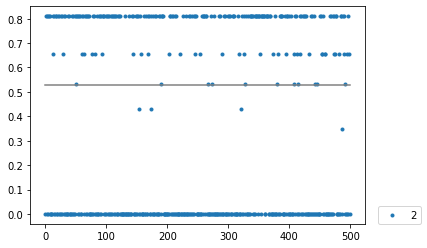

In [52]:
v, v_r, G_r = MonteCarloPredictionTarget(random_walk, policy, 0.9, 0.5, 0.01, 20, 500, False, decayType="exponential", noStepsDecay=250)
i=2
plt.scatter(np.arange(len(v_r)), G_r[:,i+1], label=i, marker='.')
plt.plot(np.arange(len(v_r)), np.ones(len(v_r))*true_est[i+1], c='gray')
plt.legend(loc=(1.04,0))
plt.show()

In [53]:
def TemporalDifferencePredictionTarget(env, policy, gamma, initial_alpha, final_alpha, noEpisodes, decayType=None, noStepsDecay=None):
    v = np.zeros(env.n_states+2) # including terminal states
    v_r = np.zeros((noEpisodes, env.n_states+2))
    G_r = np.zeros((noEpisodes, env.n_states+2))
    if not noStepsDecay:
        noStepsDecay = noEpisodes
    alphas = decayAlpha(initial_alpha, final_alpha, noStepsDecay, decayType)
    for episode in range(noEpisodes):
        if episode < noStepsDecay:
            alpha = alphas[episode]
        else:
            alpha = final_alpha
        currstate = env.reset()
        currstate += 1
        done = False
        while not done:
            action = rng.choice(np.arange(2), size=1, p=policy[currstate])[0]
            newstate, r, done, _ = env.step(action)
            newstate += 1
            td_target = r + gamma * v[newstate] # the if not done condition is redundant since v[terminal state] is always 0
            G_r[episode][currstate] = td_target
            td_error = td_target - v[currstate]
            v[currstate] += alpha * td_error
            currstate = newstate
            
        v_r[episode] = v
    
    return v, v_r, G_r

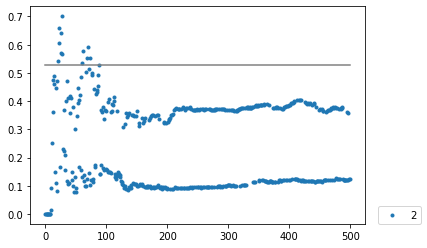

In [55]:
v, v_r, G_r = TemporalDifferencePredictionTarget(random_walk, policy, 0.9, 0.5, 0.01, 500, decayType="exponential", noStepsDecay=250)
i=2
plt.scatter(np.arange(len(v_r)), G_r[:,i+1], label=i, marker='.')
plt.plot(np.arange(len(v_r)), np.ones(len(v_r))*true_est[i+1], c='gray')
plt.legend(loc=(1.04,0))
plt.show()